# Project: Job Recommendation System!

#### Group 14, 
Members: Horm Mannchhi
         Sombath Vinun
         John Kimleang

In [160]:
# Data Preprocessing
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.stats import ttest_rel

# dowload nltk resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Load the job dataset
job_data = pd.read_csv('job_dataset.csv')
job_data = job_data.apply(lambda col: col.fillna('Not specified') if col.isnull().any() else col)

## Preprocess job dataset


In [161]:
def preprocess_text(text):
    if pd.isnull(text):
        return ''
    # Tokenize, remove stopwords, and lemmatize
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

job_data['Processed_Requirements'] = job_data['Requirements'].apply(preprocess_text)
job_data['Processed_Experience'] = job_data['Experience'].apply(preprocess_text)


## User Input

In [162]:
# Function to collect and process user input
def get_user_input():
    print("Enter your skills (comma-separated):")
    user_skills = input().split(',')
    
    # Use .apply() to process each skill
    user_skills = pd.Series(user_skills).apply(preprocess_text).tolist()

    print("Enter your years of experience:")
    user_experience = int(input())

    return user_skills, user_experience

def process_user_input(user_skills):
    return ' '.join(user_skills)


### Data Training and Recommendation
# ---------------------------------

In [163]:
# Random Recommendations: Simple TF-IDF Model
def recommend_jobs_random(user_skills, job_data, top_n=5):
    user_skills_text = process_user_input(user_skills)
    
    # Use a basic TF-IDF vectorizer with random selection
    vectorizer = TfidfVectorizer()
    job_vectors = vectorizer.fit_transform(job_data['Processed_Experience'])
    user_vector = vectorizer.transform([user_skills_text])
    
    # Compute cosine similarity
    similarities = cosine_similarity(user_vector, job_vectors).flatten()
    
    # Get top N random recommendations (not leveraging combined job fields or processed requirements)
    top_indices = similarities.argsort()[-top_n:][::-1]
    recommendations = job_data.iloc[top_indices].copy()
    recommendations['Random_Similarity'] = similarities[top_indices]
    
    return recommendations

In [164]:
# Content-Based Recommendation
def recommend_jobs_content_based(user_skills, job_data, top_n=5):
    user_skills_text = process_user_input(user_skills)
    
    # Combine job fields into a single searchable text
    job_data['Combined_Text'] = job_data['Processed_Requirements'] + ' ' + job_data['Processed_Experience']
    
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer()
    job_vectors = vectorizer.fit_transform(job_data['Combined_Text'])
    user_vector = vectorizer.transform([user_skills_text])
    
    # Compute cosine similarity
    similarities = cosine_similarity(user_vector, job_vectors).flatten()
    
    # Get top N recommendations
    top_indices = similarities.argsort()[-top_n:][::-1]
    recommendations = job_data.iloc[top_indices].copy()
    recommendations['Similarity'] = similarities[top_indices]
    
    return recommendations

In [165]:
# Collaborative Filtering
def collaborative_filtering(user_skills, job_data, top_n=5):
    user_skills_text = process_user_input(user_skills)
    job_data['Combined_Text'] = job_data['Processed_Requirements'] + ' ' + job_data['Processed_Experience']
    vectorizer = TfidfVectorizer()
    job_vectors = vectorizer.fit_transform(job_data['Combined_Text'])
    
    user_vector = vectorizer.transform([process_user_input(user_skills)])
    similarities = cosine_similarity(user_vector, job_vectors).flatten()
    
    # Get top N recommendations
    top_indices = similarities.argsort()[-top_n:][::-1]
    recommendations = job_data.iloc[top_indices].copy()
    recommendations['Collaborative_Similarity'] = similarities[top_indices]
    
    return recommendations

## Evaluation model

In [166]:
# Hybrid Model: Content-Based + Collaborative
def recommend_jobs_hybrid(user_skills, job_data, top_n=5, alpha=0.5):
    content_recommendations = recommend_jobs_content_based(user_skills, job_data, top_n)
    collaborative_recommendations = collaborative_filtering(user_skills, job_data, top_n)
    
    # Merge content-based and collaborative results
    hybrid_recommendations = pd.merge(content_recommendations, collaborative_recommendations, on='Title', how='inner')
    
    # Combine similarities with a weight parameter (alpha = 0.5 for equal weighting)
    hybrid_recommendations['Final_Score'] = alpha * hybrid_recommendations['Similarity'] + (1 - alpha) * hybrid_recommendations['Collaborative_Similarity']
    
    # Sort by the final score
    hybrid_recommendations = hybrid_recommendations.sort_values(by='Final_Score', ascending=False).head(top_n)
    
    return hybrid_recommendations

In [167]:

# Function to evaluate models with relaxed matching
def evaluate_models(user_skills, job_data, ground_truth, top_n=5):
    results = {}

    # Random_model Evaluation
    random_recommendations = recommend_jobs_random(user_skills, job_data, top_n)
    random_pred = random_recommendations['Title'].tolist()
    
    # Relaxed matching: Check if any word in predicted title matches ground truth
    def relaxed_matching(pred_titles, true_titles):
        matches = []
        for pred in pred_titles:
            match_found = False
            for true in true_titles:
                if any(word in true.lower() for word in pred.lower().split()):
                    match_found = True
                    break
            matches.append(match_found)
        return matches

    random_match = relaxed_matching(random_pred, ground_truth)

    results['Random_model'] = {
        'Precision': precision_score(random_match, [1] * len(random_match), average='macro', zero_division=0),
        'Recall': recall_score(random_match, [1] * len(random_match), average='macro', zero_division=0),
        'F1': f1_score(random_match, [1] * len(random_match), average='macro', zero_division=0)
    }

    # Hybrid Evaluation
    hybrid_recommendations = recommend_jobs_hybrid(user_skills, job_data, top_n)
    hybrid_pred = hybrid_recommendations['Title'].tolist()
    
    hybrid_match = relaxed_matching(hybrid_pred, ground_truth)

    results['Hybrid'] = {
        'Precision': precision_score(hybrid_match, [1] * len(hybrid_match), average='macro', zero_division=0),
        'Recall': recall_score(hybrid_match, [1] * len(hybrid_match), average='macro', zero_division=0),
        'F1': f1_score(hybrid_match, [1] * len(hybrid_match), average='macro', zero_division=0)
    }

    # Perform statistical test (paired t-test or other hypothesis tests) if necessary
    # Example: Compare the means of precision, recall, and f1 scores
    from scipy.stats import ttest_rel
    
    precision_diff = results['Random_model']['Precision'] - results['Hybrid']['Precision']
    recall_diff = results['Random_model']['Recall'] - results['Hybrid']['Recall']
    f1_diff = results['Random_model']['F1'] - results['Hybrid']['F1']

    # Store the results for interpretation
    results['Comparison'] = {
        'Precision Difference': precision_diff,
        'Recall Difference': recall_diff,
        'F1 Difference': f1_diff
    }

    return results

# Function to plot evaluation results
def plot_evaluation_results(results):
    # Convert the results into a DataFrame for easy plotting
    metrics = ['Precision', 'Recall', 'F1']
    
    if 'Random_model' in results and 'Hybrid' in results:
        random_based_scores = [results['Random_model'][metric] for metric in metrics]
        hybrid_scores = [results['Hybrid'][metric] for metric in metrics]

        # Check if there are any NaN or None values
        if any(np.isnan(random_based_scores)) or any(np.isnan(hybrid_scores)):
            print("Warning: Some metrics contain invalid (NaN) values. Check your evaluation.")
            return

        # Create the DataFrame for plotting
        df = pd.DataFrame({
            'Metric': metrics,
            'Random_model': random_based_scores,
            'Hybrid': hybrid_scores
        })

        df.set_index('Metric', inplace=True)

        # Plot the results
        df.plot(kind='bar', figsize=(8, 4), color=['skyblue', 'lightgreen'])
        plt.title('Model Evaluation Comparison (Random Model vs Hybrid)')
        plt.ylabel('Score')
        plt.xlabel('Evaluation Metric')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

    else:
        print("Error: Evaluation results are incomplete or invalid.")



## Data Visualization
# ---------------------------------

In [168]:
def plot_skill_demand(job_data):
    all_skills = ' '.join(job_data['Processed_Requirements']).split()
    skill_counts = pd.Series(all_skills).value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    skill_counts.plot(kind='bar', color='skyblue')
    plt.title('Top 10 In-Demand Skills')
    plt.xlabel('Skills')
    plt.ylabel('Frequency')
    plt.show()

In [169]:
def plot_popular_jobs_wordcloud(job_data):
    job_titles = ' '.join(job_data['Title'].dropna().tolist())
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(job_titles)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Popular Job Titles', fontsize=16)
    plt.show()

# plot_skill_demand(job_data)
# plot_popular_jobs_wordcloud(job_data)


### Testing And Demo

Enter your skills (comma-separated):


 Management, financial


Enter your years of experience:


 1


0           Finance Manager
1    Senior Finance officer
2                Accountant
3                Accountant
4                Accountant
Name: Title, dtype: object
Evaluation Results: {'Random_model': {'Precision': 0.1, 'Recall': 0.5, 'F1': 0.16666666666666666}, 'Hybrid': {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}, 'Comparison': {'Precision Difference': 0.1, 'Recall Difference': 0.5, 'F1 Difference': 0.16666666666666666}}


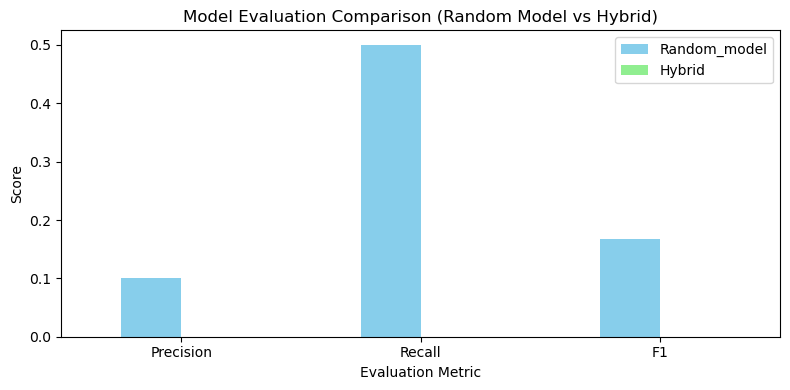

In [172]:

print("Enter your skills (comma-separated):")
user_skills_input = input().split(',')
user_skills_input = [skill.strip().lower() for skill in user_skills_input]

print("Enter your years of experience:")
user_experience_input = input()

job_data['Processed_Requirements'] = job_data['Requirements'].apply(preprocess_text)
job_data['Processed_Experience'] = job_data['Experience'].apply(preprocess_text)

ground_truth = ['AI Specialist', 'Data Analyst', 'National Data Analyst', 'Python Developer', 'Data Scientist'] 

recommendation_jobs = recommend_jobs_hybrid(user_skills_input, job_data)

print(recommendation_jobs['Title'])

# Evaluate models
evaluation_results = evaluate_models(user_skills_input, job_data, ground_truth, top_n=5)

# plot_skill = plot_skill_demand(job_data)
# print("plot_skill:", plot_skill)

# plot_popular_jobs = plot_popular_jobs_wordcloud(job_data)
# print("plot_popular_jobs:", plot_popular_jobs)

print("Evaluation Results:", evaluation_results)

plot_evaluation_results(evaluation_results)
